In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from skimage.morphology import remove_small_objects
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
import nibabel as nib
import scipy.stats
from scipy.stats import mannwhitneyu, ttest_ind, ranksums
from scipy.ndimage import gaussian_filter
from scipy.ndimage import binary_dilation, binary_erosion
from scipy.stats import norm
from scipy.stats import wilcoxon
from scipy.stats import ranksums

np.random.seed(42)

In [6]:
def dice_score_per_intensity(array1, array2, intensity_list):
     
    dice_scores = []

    for intensity in intensity_list:
        mask1 = array1 == intensity
        
        # for some reason the GS segmentations are in LR flipped form to the unet outputs
        # just flipping back here...
        if 1000 < intensity < 2000:
            mask2 = array2 == intensity + 1000
        else:
            mask2 = array2 == intensity - 1000

        intersection = np.sum(mask1 & mask2)  
        sum_mask1 = np.sum(mask1)
        sum_mask2 = np.sum(mask2)

        # Dice per intensity
        if sum_mask1 + sum_mask2 == 0:  # no intensities present in either. Just set to 0
            dice_score = 0.0
        else:
            dice_score = (2. * intersection)/(sum_mask1 + sum_mask2) 

        dice_scores.append(dice_score)
        
    return np.array(dice_scores)


def hd_score_per_intensity(array1, array2, intensity_list):

    hd_scores = []
    for intensity in intensity_list:
        mask1 = array1 == intensity
        
        ## same deal as for the above dice function
        if 1000 < intensity < 2000:
            mask2 = array2 == intensity + 1000
        else:
            mask2 = array2 == intensity - 1000
            
        sum_mask1 = np.sum(mask1)
        sum_mask2 = np.sum(mask2)
 
        if sum_mask2 == 0:    #HD would be infinite if a segmentation is missing...
            hd_scores.append(None)
        else:
            hd_score = average_hausdorff_distance(mask1, mask2)
            hd_scores.append(hd_score)

    return np.array(hd_scores)



def compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path):
    dice_array = np.zeros((len(case_list),len(intensity_list)))

    counter = 0
    for case in case_list:
        #print("starting case: ", case)
        dir_case = os.path.join(basepath,case)

        seg_vol_gt = nib.load(os.path.join(dir_case,seg_gt_path))
        seg_vol_gt_np = seg_vol_gt.get_fdata()

        seg_vol_unet = nib.load(os.path.join(dir_case,seg_unet_path))
        seg_vol_unet_np = seg_vol_unet.get_fdata()
        
        ## remove small stray segs which aren't connected (<10 voxels) 
        for intensity in intensity_list:
            mask = seg_vol_unet_np == intensity
            cleaned_mask = remove_small_objects(mask, min_size=10,connectivity=2)
            seg_vol_unet_np[mask & ~cleaned_mask] = 0  # Set the small objects to 0
        
        

        dice_out = dice_score_per_intensity(seg_vol_gt_np, seg_vol_unet_np, BSB_intensity_list)
        dice_array[counter,:] = dice_out
        counter += 1
    return dice_array


def compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path):
    hd_array = np.zeros((len(case_list),len(intensity_list)))

    counter = 0
    for case in case_list:
        #print("case is: ", case)
        dir_case = os.path.join(basepath,case)

        seg_vol_gt = nib.load(os.path.join(dir_case,seg_gt_path))
        seg_vol_gt_np = seg_vol_gt.get_fdata()

        seg_vol_unet = nib.load(os.path.join(dir_case,seg_unet_path))
        seg_vol_unet_np = seg_vol_unet.get_fdata()
        
        ## remove small stray segs which aren't connected (<10 voxels) 
        for intensity in intensity_list:
            mask = seg_vol_unet_np == intensity
            cleaned_mask = remove_small_objects(mask, min_size=10,connectivity=2)
            seg_vol_unet_np[mask & ~cleaned_mask] = 0  # Set the small objects to 0

        hd_out = hd_score_per_intensity(seg_vol_gt_np, seg_vol_unet_np, BSB_intensity_list)
        if np.any(hd_out == None):
            #print("found None in HD array (unet probably outputted an empty seg): ", hd_out)
            hd_array[counter,:] = hd_out
            counter +=1
        else:
            hd_array[counter,:] = hd_out
            #print("in ", case, ": HD ", hd_out)
            counter += 1
    return hd_array


def sum_of_minimum_distances(coords1, coords2):
    """
    Calculate the sum of all minimum distances from each point in coords1 to the closest point in coords2.
    """
    return np.sum([np.min(np.linalg.norm(coords2 - point, axis=1)) for point in coords1])



def average_hausdorff_distance(array1, array2):
    # Extract coordinates
    coords1 = np.argwhere(array1)
    coords2 = np.argwhere(array2)

    # Calculate the directed Hausdorff distances from array1 to array2 and vice versa
    dist1 = directed_hausdorff(coords1, coords2, seed=None)[0]
    dist2 = directed_hausdorff(coords2, coords1, seed=None)[0]

    # Calculate average hausdorff dist
    hausdorff_dist = (dist1 + dist2)/2

    return hausdorff_dist


def calculate_p_values(cluster,alt='two-sided'):
    p_values = []
    for i in range(1, len(cluster)):
        stat, p_value = wilcoxon(cluster[0], cluster[i],alternative=alt)
        p_values.append(p_value)
    return p_values


In [7]:
ds_factor_list = [1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6]
ds_factor_list_with_nativeres = np.insert(ds_factor_list, 0, 1.0)
ds_factor_list_names = ["ds1","ds2","ds3","ds4","ds5","ds6","ds7","ds8","ds9","ds10","ds11","ds12","ds13"]


case_list_basepath = "/Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS"
case_list_GT_basepath = "/Users/markolchanyi/Desktop/BSB_validation/ALL_MANUAL_ANNOTATIONS_VALID"

case_list_HCP_validation_ORIG = ["subject_101107",
                                "subject_103414",
                                "subject_105115",
                                "subject_110411",
                                "subject_208226",
                                "subject_113619",
                                "subject_116524",
                                "subject_124422",
                                "subject_131722",
                                "subject_133019",
                                "subject_133928",
                                "subject_135225",
                                "subject_136833",
                                "subject_140925",
                                "subject_144832"]

case_list_EXC = ["subject_C1_rotated",
                "subject_C2",
                "subject_C4",
                "subject_EXC007",
                "subject_EXC012",
                "subject_EXC020",
                "subject_EXC021"]

case_list_ADNI = ["subject_002_S_4213",
                  "subject_002_S_4225",
                  "subject_002_S_6009",
                  "subject_002_S_6030",
                  "subject_002_S_6053",
                  "subject_003_S_6259",
                  "subject_003_S_6260",
                  "subject_003_S_6307",
                  "subject_012_S_4643",
                  "subject_016_S_4951"]



BSB_intensity_list = [1001,2001,1002,2002,1003,2003,1004,2004,1005,2005,1006,2006,1007,2007,1008,2008]
BSB_intensity_list_L = [1001,1002,1003,1004,1005,1006,1007,1008]
BSB_intensity_list_R = [2001,2002,2003,2004,2005,2006,2007,2008]




In [8]:
### FOR HCP Validation ###

dice_array_hcp_downsample = np.zeros((len(case_list_HCP_validation_ORIG),len(BSB_intensity_list),len(ds_factor_list)+1))
hd_array_hcp_downsample = np.zeros((len(case_list_HCP_validation_ORIG),len(BSB_intensity_list),len(ds_factor_list)+1))

for case in case_list_HCP_validation_ORIG:
        dir_case_input = os.path.join(case_list_GT_basepath,case)
        dir_case_output = os.path.join(case_list_basepath,case)
        os.system("mri_convert " + os.path.join(dir_case_input,"segs","all_aan_manual_anno.nii.gz") + " " + os.path.join(dir_case_output,"segs","seg_conformed.nii.gz") + " -rl " + os.path.join(dir_case_output,"results_bsb_rawres","bsNet.crfseg.mgz") + " -rt nearest -odt float")

print("\n\n starting raw \n\n") 
case_list = case_list_HCP_validation_ORIG
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_bsb_rawres_nativeres","bsNet.crfseg.mgz")

dice_array_hcp_downsample[:,:,0] = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_hcp_downsample[:,:,0] = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)


for count, ds_factor_name in enumerate(ds_factor_list_names):
    print("**** starting factor", str(ds_factor_name)," *****")

    case_list = case_list_HCP_validation_ORIG
    intensity_list = BSB_intensity_list
    basepath = case_list_basepath
    seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
    seg_unet_path = os.path.join("results_bsb_" + ds_factor_name,"bsNet.crfseg.mgz")

    dice_array_hcp_downsample[:,:,count+1] = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
    print("HD is: ", compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path))
    hd_array_hcp_downsample[:,:,count+1] = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
    
    



 starting raw 


**** starting factor ds1  *****
HD is:  [[2.5        1.82514077 1.70710678 1.70710678 1.41421356 1.93185165
  1.57313218 1.93185165 1.41421356 1.57313218 1.82514077 1.20710678
  3.70710678 2.08113883 1.57313218 1.72474487]
 [1.73205081 2.09077028 2.66880104 2.67944947 1.82514077 2.09077028
  2.09077028 1.98405939 1.98405939 2.23606798 1.82514077 2.22474487
  3.70710678 4.47213595 1.20710678 1.41421356]
 [5.08844818 3.86938444 2.1583124  2.50988242 1.20710678 2.34277886
  2.23606798 2.09077028 2.70710678 3.99031531 1.8660254  2.11803399
  4.09807621 4.17921504 2.12132034 1.82514077]
 [1.20710678 1.5        1.82514077 1.5        1.20710678 2.23606798
  1.41421356 1.41421356 1.70710678 1.41421356 1.         1.3660254
  2.76865959 3.25661654 1.3660254  1.3660254 ]
 [2.6583124  1.98405939 2.56155281 2.56155281 1.72474487 2.56155281
  1.41421356 2.53224755 2.34277886 2.6583124  1.41421356 1.
  2.92757822 3.6925824  2.44948974 2.34277886]
 [2.69917282 2.69917282 1.91421356 

**** starting factor ds4  *****
HD is:  [[2.3660254  2.61803399 1.61803399 1.70710678 1.41421356 1.82514077
  1.57313218 2.11803399 1.57313218 1.98405939 1.82514077 1.20710678
  3.3660254  2.28824561 1.72474487 2.        ]
 [2.61803399 2.72474487 3.10209338 2.67944947 1.82514077 1.93185165
  1.98405939 2.11803399 1.82514077 2.         1.73205081 2.11803399
  3.90740667 4.22012737 1.20710678 1.70710678]
 [5.62310563 4.83021241 2.30277564 2.50988242 1.61803399 2.61803399
  2.23606798 1.82514077 3.3660254  4.66334583 1.8660254  2.11803399
  4.09807621 4.17921504 2.12132034 1.82514077]
 [1.70710678 1.5        1.61803399 1.5        1.41421356 2.23606798
  1.70710678 1.41421356 1.82514077 1.82514077 1.20710678 1.8660254
  2.76865959 3.70710678 1.57313218 1.57313218]
 [2.98734575 3.04547488 2.56155281 2.79128785 2.1583124  3.25661654
  1.41421356 2.12132034 2.72474487 2.72474487 1.82514077 1.41421356
  3.1795868  3.81061639 2.72474487 2.69917282]
 [2.69917282 3.23935433 2.08113883 2.         

**** starting factor ds7  *****
HD is:  [[2.72474487 3.08113883 1.5        1.70710678 1.70710678 1.8660254
  1.41421356 2.11803399 1.73205081 2.34277886 1.70710678 1.57313218
  3.3660254  2.58113883 1.82514077 2.20710678]
 [3.1795868  2.99535239 3.1795868  2.56155281 2.12132034 1.91421356
  2.44948974 2.23606798 1.98405939 1.8660254  2.09077028 2.5
  4.04138127 4.86479982 1.5        1.82514077]
 [6.05521679 5.47579763 2.         2.12132034 2.12132034 2.34277886
  1.82514077 1.98405939 3.61803399 4.7405194  2.         2.11803399
  3.53553391 3.64269164 2.12132034 1.98405939]
 [2.11803399 1.82514077 2.08113883 1.61803399 1.41421356 2.34277886
  1.98405939 1.82514077 2.41421356 2.34277886 1.5        1.98405939
  2.82842712 3.25661654 1.41421356 1.57313218]
 [       nan        nan 2.20710678 2.37082869 2.82842712 3.55860781
  2.50988242 2.50988242 3.9086689  3.41547595 2.34277886 2.09077028
  4.12132034 4.5634111  3.28629768 3.23945123]
 [2.8058837  3.09557356 2.56155281 2.08113883 2.36602

**** starting factor ds10  *****
HD is:  [[2.77634638 2.98886268 2.22474487 2.5        2.11803399 2.23606798
  2.09077028 2.23606798 2.44716423 2.82842712 1.82514077 1.41421356
  3.61803399 2.58113883 2.11803399 2.23606798]
 [4.31975162 3.34520788 2.34277886 1.93185165        nan 2.57793547
  2.34277886 2.                nan 2.76865959 1.93185165 2.34277886
  4.04138127 4.86479982 2.56155281 2.36541918]
 [7.46147838 7.03043941 2.3660254  2.61803399 2.30277564 2.69917282
  2.57793547 1.61803399 4.65356789 7.03834842 1.98405939 2.11803399
  3.73861279 4.42630699 2.20710678 2.22474487]
 [2.69917282 2.69917282 2.28824561 2.20710678 1.41421356 2.72474487
  2.23606798 2.34277886 2.91421356 4.20156212 1.5        1.70710678
  3.23935433 3.91421356 1.41421356 1.70710678]
 [       nan        nan 3.1583124  3.02752051 5.31687901        nan
  3.73861279 3.66227766        nan        nan        nan        nan
  3.93238151 4.47213595 3.30277564 2.50988242]
 [3.08113883 3.23945123 2.50988242 2.       

**** starting factor ds13  *****
HD is:  [[        nan         nan         nan         nan         nan 28.45762983
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan 41.79383365 29.64361572 32.12136253
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan 15.46345049         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan  

In [9]:
dice_averaged_over_subjects_hcp = np.mean(dice_array_hcp_downsample,axis=(0,1))
dice_std_over_subjects_hcp = np.std(dice_array_hcp_downsample,axis=(0,1))
hd_averaged_over_subjects_hcp = np.nanmean(hd_array_hcp_downsample,axis=(0,1))
hd_std_over_subjects_hcp = np.nanstd(hd_array_hcp_downsample,axis=(0,1))

print(dice_averaged_over_subjects_hcp)
print(dice_std_over_subjects_hcp)

print(hd_averaged_over_subjects_hcp)
print(hd_std_over_subjects_hcp)

[0.6980505  0.67791459 0.66789935 0.65337779 0.63975491 0.61816062
 0.60292814 0.58724328 0.56757697 0.541327   0.48871347 0.27169544
 0.07590652 0.        ]
[0.10439064 0.10217049 0.10190021 0.10020429 0.09914316 0.1048677
 0.11343128 0.11685789 0.13042336 0.14387904 0.17951569 0.25168899
 0.16774694 0.        ]
[2.10763587 0.67791459 0.66789935 0.65337779 0.63975491 0.61816062
 0.60292814 0.58724328 0.56757697 0.541327   0.48871347 0.27169544
 0.07590652 0.        ]
[0.69346496 0.10217049 0.10190021 0.10020429 0.09914316 0.1048677
 0.11343128 0.11685789 0.13042336 0.14387904 0.17951569 0.25168899
 0.16774694 0.        ]


In [10]:
### FOR ADNI Validation ###

dice_array_adni_downsample = np.zeros((len(case_list_ADNI),len(BSB_intensity_list),len(ds_factor_list)+1))
hd_array_adni_downsample = np.zeros((len(case_list_ADNI),len(BSB_intensity_list),len(ds_factor_list)+1))


for case in case_list_ADNI:
        dir_case_input = os.path.join(case_list_GT_basepath,case)
        dir_case_output = os.path.join(case_list_basepath,case)
        os.system("mri_convert " + os.path.join(dir_case_input,"segs","all_aan_manual_anno.nii.gz") + " " + os.path.join(dir_case_output,"segs","seg_conformed.nii.gz") + " -rl " + os.path.join(dir_case_output,"results_bsb_rawres","bsNet.crfseg.mgz") + " -rt nearest -odt float")

print("\n\n starting raw \n\n") 
case_list = case_list_ADNI
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_bsb_rawres_nativeres","bsNet.crfseg.mgz")

dice_array_adni_downsample[:,:,0] = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_adni_downsample[:,:,0] = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)

for count, ds_factor_name in enumerate(ds_factor_list_names):
    print("**** starting factor", str(ds_factor_name)," *****")

    case_list = case_list_ADNI
    intensity_list = BSB_intensity_list
    basepath = case_list_basepath
    seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
    seg_unet_path = os.path.join("results_bsb_" + ds_factor_name,"bsNet.crfseg.mgz")

    dice_array_adni_downsample[:,:,count+1] = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
    print("HD is: ", compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path))
    hd_array_adni_downsample[:,:,count+1] = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
    
    



 starting raw 


**** starting factor ds1  *****
HD is:  [[1.70710678 2.23606798 2.28824561 2.20710678 2.09077028 2.5
  3.46108803 1.98405939 2.23205081 2.23205081 3.29128785 2.50988242
  3.30518299 3.81061639 2.76865959 1.82514077]
 [1.8660254  2.77634638 2.92080963 2.58113883 1.61803399 2.5243378
  3.10209338 2.20710678 2.08113883 2.37082869 1.5        1.5
  2.77634638 2.11803399 2.08113883 2.99839463]
 [3.28504226 2.09077028 3.56995275 4.85969138 1.82514077 2.09077028
  1.98405939 2.         2.20710678 1.93185165 1.82514077 1.57313218
  2.57793547 3.15731325 3.15731325 3.5793881 ]
 [2.11803399 1.70710678 2.22474487 2.63895843 1.61803399 2.12132034
  1.57313218 1.82514077 2.72474487 2.53224755 1.         1.41421356
  1.82514077 1.82514077 1.20710678 1.93185165]
 [2.09077028 2.50988242 2.11803399 1.82514077 2.12132034 1.5
  3.09557356 1.70710678 3.28629768 2.12132034 1.70710678 2.61803399
  2.88305727 3.12132034 1.57313218 3.37082869]
 [2.8058837  2.3660254  2.23606798 2.11803399 1.

**** starting factor ds6  *****
HD is:  [[ 2.72474487  2.34277886  1.93185165  2.88655625  2.66880104  3.46324187
   4.45559483  2.34277886  2.88655625  2.50988242  3.15731325  2.41421356
   3.9086689   3.85664678  2.5243378   2.11803399]
 [ 2.53224755  4.53917872  2.34277886  2.28824561  3.25661654  2.99839463
   4.15941525  3.06155281  3.582207    4.17423461  2.12132034  2.
   2.44948974  2.34277886  1.70710678  2.99839463]
 [ 3.38391447  3.02752051  3.84520788  4.86479982  2.3660254   2.98734575
   3.25661654  4.24264069  2.76865959  3.39968918  2.11803399  2.34277886
   2.28824561  2.7368541   2.7368541   3.31551515]
 [ 3.70550141  3.46324187  2.20710678  2.99535239  2.36541918  2.12132034
   4.06758752  2.36541918  3.55860781  2.3660254   1.73205081  1.5
   2.34277886  2.61803399  1.3660254   1.57313218]
 [ 2.92757822  3.1795868   1.72474487  1.61803399  4.082207    3.15659652
   4.38702253  3.23606798  3.35410197  2.82842712  1.57313218  3.16227766
   3.23945123  3.23935433  2.23

**** starting factor ds11  *****
HD is:  [[        nan         nan  4.40155931  2.72474487         nan         nan
   4.43673962         nan         nan         nan         nan         nan
          nan 11.44256206  3.28629768         nan]
 [ 6.89491306         nan         nan         nan         nan         nan
   5.55478664         nan         nan         nan         nan         nan
   6.32182538 14.91651294  2.88305727         nan]
 [ 7.85577516  9.27817459  6.36396103  6.24968268         nan         nan
   3.582207    4.80116263         nan         nan         nan         nan
   3.40932184  3.34606521  4.13064859  4.        ]
 [        nan         nan  3.61803399  3.66514667         nan  5.63572141
   4.74341649  5.15331193         nan         nan         nan         nan
   2.63895843  2.69917282  2.3660254   2.34277886]
 [        nan         nan  8.51455467         nan         nan         nan
   3.72474487         nan         nan         nan         nan         nan
  13.09200326 1

In [11]:
dice_averaged_over_subjects_adni = np.mean(dice_array_adni_downsample,axis=(0,1))
dice_std_over_subjects_adni = np.std(dice_array_adni_downsample,axis=(0,1))
hd_averaged_over_subjects_adni = np.nanmean(hd_array_adni_downsample,axis=(0,1))
hd_std_over_subjects_adni = np.nanstd(hd_array_adni_downsample,axis=(0,1))


print(dice_averaged_over_subjects_adni)
print(hd_averaged_over_subjects_adni)

[0.66436226 0.6585272  0.646434   0.63561948 0.62107891 0.59518316
 0.57010561 0.52597571 0.48030299 0.40066076 0.27899053 0.16094133
 0.07521864 0.01874913]
[2.33559137 2.27704711 2.32017275 2.4221604  2.49639765 2.75384468
 2.90441229 3.22355115 3.60636396 4.05773138 4.46448387 5.41513222
 7.41137015 8.73670403]


In [12]:
### FOR EXC Validation ###

dice_array_exc_downsample = np.zeros((len(case_list_EXC),len(BSB_intensity_list),len(ds_factor_list)+1))
hd_array_exc_downsample = np.zeros((len(case_list_EXC),len(BSB_intensity_list),len(ds_factor_list)+1))


for case in case_list_EXC:
        dir_case_input = os.path.join(case_list_GT_basepath,case)
        dir_case_output = os.path.join(case_list_basepath,case)
        os.system("mri_convert " + os.path.join(dir_case_input,"segs","all_aan_manual_anno.nii.gz") + " " + os.path.join(dir_case_output,"segs","seg_conformed.nii.gz") + " -rl " + os.path.join(dir_case_output,"results_bsb_rawres","bsNet.crfseg.mgz") + " -rt nearest -odt float")

print("\n\n starting raw \n\n") 
case_list = case_list_EXC
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_bsb_rawres_nativeres","bsNet.crfseg.mgz")

dice_array_exc_downsample[:,:,0] = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_exc_downsample[:,:,0] = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)



for count, ds_factor_name in enumerate(ds_factor_list_names):
    print("**** starting factor", str(ds_factor_name)," *****")

    case_list = case_list_EXC
    intensity_list = BSB_intensity_list
    basepath = case_list_basepath
    seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
    seg_unet_path = os.path.join("results_bsb_" + ds_factor_name,"bsNet.crfseg.mgz")

    dice_array_exc_downsample[:,:,count+1] = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
    hd_array_exc_downsample[:,:,count+1] = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
    
    
    



 starting raw 


**** starting factor ds1  *****
**** starting factor ds2  *****
**** starting factor ds3  *****
**** starting factor ds4  *****
**** starting factor ds5  *****
**** starting factor ds6  *****
**** starting factor ds7  *****
**** starting factor ds8  *****
**** starting factor ds9  *****
**** starting factor ds10  *****
**** starting factor ds11  *****
**** starting factor ds12  *****
**** starting factor ds13  *****


In [13]:
dice_averaged_over_subjects_exc = np.mean(dice_array_exc_downsample,axis=(0,1))
dice_std_over_subjects_exc = np.std(dice_array_exc_downsample,axis=(0,1))
hd_averaged_over_subjects_exc = np.nanmean(hd_array_exc_downsample,axis=(0,1))
hd_std_over_subjects_exc = np.nanstd(hd_array_exc_downsample,axis=(0,1))
print(dice_averaged_over_subjects_exc)

[0.6153412  0.55694866 0.53136125 0.48719046 0.43502256 0.35132487
 0.28907339 0.17371741 0.03582958 0.         0.         0.
 0.         0.        ]


<ipython-input-14-ebcff9dde285>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


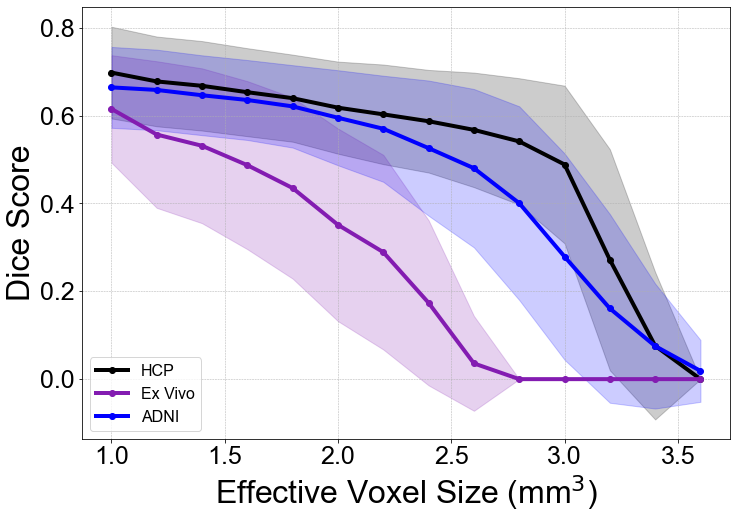

In [14]:
plt.rcParams['font.family'] = 'Arial'
#plt.rcParams['font.weight'] = 'bold'

fig = plt.figure(figsize=(15, 10))
plot_area = [0.2, 0.2, 0.6, 0.6]  
ax = fig.add_axes(plot_area)

# Plot the mean line
plt.plot(ds_factor_list_with_nativeres, dice_averaged_over_subjects_hcp, '-o', color='black', label='HCP', linewidth=4)
plt.plot(ds_factor_list_with_nativeres, dice_averaged_over_subjects_exc, '-o', color='#831CB1', label='Ex Vivo', linewidth=4)
plt.plot(ds_factor_list_with_nativeres, dice_averaged_over_subjects_adni, '-o', color='blue', label='ADNI', linewidth=4)

# Add shading for the standard deviation
plt.fill_between(ds_factor_list_with_nativeres, dice_averaged_over_subjects_hcp - dice_std_over_subjects_hcp, dice_averaged_over_subjects_hcp + dice_std_over_subjects_hcp, color='black', alpha=0.2)
plt.fill_between(ds_factor_list_with_nativeres, dice_averaged_over_subjects_exc - dice_std_over_subjects_exc, dice_averaged_over_subjects_exc + dice_std_over_subjects_exc, color='#831CB1', alpha=0.2)
plt.fill_between(ds_factor_list_with_nativeres, dice_averaged_over_subjects_adni - dice_std_over_subjects_adni, dice_averaged_over_subjects_adni + dice_std_over_subjects_adni, color='blue', alpha=0.2)

plt.ylabel('Dice Score', fontsize=32)
plt.xlabel('Effective Voxel Size (mm$^3$)', fontsize=32)
plt.xticks(fontsize=25, fontweight='regular')
plt.yticks(fontsize=25, fontweight='regular')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc="lower left", fontsize=22, prop={'size': 16, 'weight': 'regular'})

plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/Dice_resolution.png', dpi=300)
plt.show()

<ipython-input-15-c57a19b01590>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


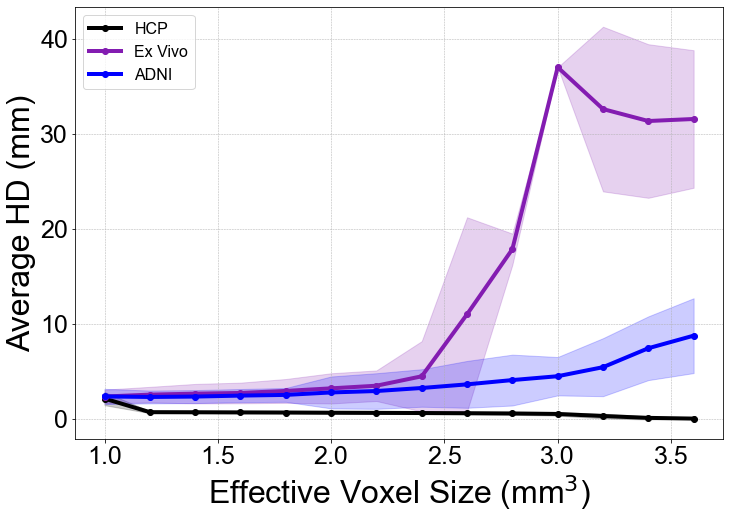

In [15]:
plt.rcParams['font.family'] = 'Arial'
#plt.rcParams['font.weight'] = 'bold'

fig = plt.figure(figsize=(15, 10))
plot_area = [0.2, 0.2, 0.6, 0.6] 
ax = fig.add_axes(plot_area)

# Plot the mean line
plt.plot(ds_factor_list_with_nativeres, hd_averaged_over_subjects_hcp, '-o', color='black', label='HCP', linewidth=4)
plt.plot(ds_factor_list_with_nativeres, hd_averaged_over_subjects_exc, '-o', color='#831CB1', label='Ex Vivo', linewidth=4)
plt.plot(ds_factor_list_with_nativeres, hd_averaged_over_subjects_adni, '-o', color='blue', label='ADNI', linewidth=4)

# Add shading for the standard deviation
plt.fill_between(ds_factor_list_with_nativeres, hd_averaged_over_subjects_hcp - hd_std_over_subjects_hcp, hd_averaged_over_subjects_hcp + hd_std_over_subjects_hcp, color='black', alpha=0.2)
plt.fill_between(ds_factor_list_with_nativeres, hd_averaged_over_subjects_exc - hd_std_over_subjects_exc, hd_averaged_over_subjects_exc + hd_std_over_subjects_exc, color='#831CB1', alpha=0.2)
plt.fill_between(ds_factor_list_with_nativeres, hd_averaged_over_subjects_adni - hd_std_over_subjects_adni, hd_averaged_over_subjects_adni + hd_std_over_subjects_adni, color='blue', alpha=0.2)

plt.ylabel('Average HD (mm)', fontsize=32)
plt.xlabel('Effective Voxel Size (mm$^3$)', fontsize=32)
plt.xticks(fontsize=25, fontweight='regular')
plt.yticks(fontsize=25, fontweight='regular')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc="upper left", fontsize=22, prop={'size': 16, 'weight': 'regular'})

plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/HD_resolution.png', dpi=300)
plt.show()